# Finding Velocity of Catcher's Throw and Distance of 1st Base Runner from 1st Base for Stolen Base Run


## Importing a collection of useful R packages

In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Loading data (uploaded files from jupyter notebook)
upload files from local computer to jupyter notebook

In [ ]:
file_list <- list.files(pattern = "^game_events.*\\.csv$")

combined_event_data <- data.frame()
game_id <- 1
columns_to_select = c("game_str", "play_per_game", "play_id", "timestamp", "player_position", "event_code")
for (file in file_list) {
  #read certain columns in csv files, add game_id column with unique id
  event_data <- read_csv(
    paste0("/content/", file),
    show_col_types = FALSE) %>%
      select(all_of(columns_to_select)) %>%
        mutate(game_id = game_id) %>%
          relocate(game_id, .after = game_str)
  combined_event_data <- bind_rows(combined_event_data, event_data)
  game_id <- game_id + 1 # Increment game_id counter
}

In [ ]:
#checking if data successfully loaded
combined_event_data %>% head(5)
glimpse(combined_event_data)

,game_str,game_id,play_per_game,play_id,timestamp,player_position,event_code
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1900_01_TeamKJ_TeamB,1,1,1,20549,1,1
2,1900_01_TeamKJ_TeamB,1,1,1,21044,2,2
3,1900_01_TeamKJ_TeamB,1,1,1,21044,0,5
4,1900_01_TeamKJ_TeamB,1,2,2,31738,1,1
5,1900_01_TeamKJ_TeamB,1,2,2,32233,2,2


Rows: 103,444
Columns: 7
$ game_str        <chr> "1900_01_TeamKJ_TeamB", "1900_01_TeamKJ_TeamB", "1900_…
$ game_id         <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ play_per_game   <dbl> 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, …
$ play_id         <dbl> 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, …
$ timestamp       <dbl> 20549, 21044, 21044, 31738, 32233, 32233, 44049, 44511…
$ player_position <dbl> 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, …
$ event_code      <dbl> 1, 2, 5, 1, 2, 5, 1, 2, 5, 1, 2, 5, 1, 2, 5, 1, 2, 5, …


## Find plays where catcher throws to 2B or SS right after a pitch
(to simulate a play with a stolen base attempt)

In [ ]:
#we want to find plays where the catcher throws to 2B right after a pitch (to simulate a play with a stolen base attempt)
find_stolen_base_plays <- function(event_data, infielder) {
  result <- event_data %>% group_by(game_id, play_id) %>% #each scenario will be a different play
    filter(n() > 3) %>% #n() > 3 means the standard pitch, miss, catch (or nothing eventful happens) is eliminated
      filter((player_position == 2 & event_code == 3) | #catcher throws ball
              (player_position == infielder & event_code == 2)) %>% #infielder catches the ball
        group_by(game_id, play_id) %>%
          filter(all(c(any(player_position == 2 & event_code == 3), #ensures only (2,3) row and (infielder,2) row exists for a play
                 any(player_position == infielder & event_code == 2))))
  return(result)
}
stolen_base_plays_2b <- find_stolen_base_plays(combined_event_data, 4)
stolen_base_plays_ss <- find_stolen_base_plays(combined_event_data, 6)

### Edge cases in filtering, that were found when calculating velocities

**game_id**: 87

**play_id**: 60

2 cases of (6,2) (player_position, event_code) back to back

In [ ]:
stolen_base_plays_ss %>% filter(game_id == 87, play_id == 60)

game_str,game_id,play_per_game,play_id,timestamp,player_position,event_code
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1903_25_TeamNK_TeamB,87,62,60,2168365,2,3
1903_25_TeamNK_TeamB,87,62,60,2169765,6,2
1903_25_TeamNK_TeamB,87,62,60,2172015,6,2


**Problem**: Hindered velocity calculation since didn't know which timestamp to use for (6,2)

**Analysis of play**:
* pitcher throws ball
* catcher catches ball and throws (assumingly to SS)
* SS catches ball but perhaps drops it on accident
* the ball deflects off 1st base runner who is running to steal 2nd base
* ball hits the ground, 1st base runner successfully steals 2nd base
* SS picks up the ball
* end of play

**Solution**:
Since we want the time SS catches ball from catcher, we will use earlier timestamp

In [ ]:
combined_event_data %>%
  filter(game_id == 87, play_id == 60)

game_str,game_id,play_per_game,play_id,timestamp,player_position,event_code
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1903_25_TeamNK_TeamB,87,62,60,2167165,1,1
1903_25_TeamNK_TeamB,87,62,60,2167665,2,2
1903_25_TeamNK_TeamB,87,62,60,2168365,2,3
1903_25_TeamNK_TeamB,87,62,60,2169765,6,2
1903_25_TeamNK_TeamB,87,62,60,2169915,6,3
1903_25_TeamNK_TeamB,87,62,60,2169965,11,9
1903_25_TeamNK_TeamB,87,62,60,2170865,255,16
1903_25_TeamNK_TeamB,87,62,60,2172015,6,2
1903_25_TeamNK_TeamB,87,62,60,2173665,0,5


In [ ]:
#remove second (6,2) row
stolen_base_plays_ss <- stolen_base_plays_ss %>% filter(!(game_id == 87 & play_id == 60 & timestamp == 2172015))

## Calculate velocity of the ball catcher throws to infielder (2B or SS)

### Calculate on one example first (isolate one stolen base play to work on)

We'll use example for game between TeamKK and TeamB, on the 56th play

In [ ]:
one_play = stolen_base_plays_2b %>%
  filter(game_id == 5, play_id == 56) %>%
    filter((player_position == 2 & event_code == 3) |
           (player_position == 4 & event_code == 2))
one_play

game_str,game_id,play_per_game,play_id,timestamp,player_position,event_code
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1900_05_TeamKK_TeamB,5,56,56,2231896,2,3
1900_05_TeamKK_TeamB,5,56,56,2233184,4,2


---
Combine player_pos table by corresponding game_id and play

In [ ]:
game_5_team_b = read_csv("/content/player_pos-1900_05_TeamKK_TeamB.csv", show_col_types = FALSE)
glimpse(game_5_team_b)

New names:
• `` -> `...1`


Rows: 177,178
Columns: 7
$ ...1            <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,…
$ game_str        <chr> "1900_05_TeamKK_TeamB", "1900_05_TeamKK_TeamB", "1900_…
$ play_id         <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ timestamp       <dbl> 50193, 50226, 50259, 50292, 50325, 50358, 50391, 50424…
$ player_position <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, …
$ field_x         <dbl> -1.0803, -1.0980, -1.1160, -1.1337, -1.1517, -1.1700, …
$ field_y         <dbl> 56.0139, 55.9317, 55.8495, 55.7670, 55.6845, 55.6020, …


In [ ]:
b5_stolen_base_play <- game_5_team_b %>% filter(play_id == 56, player_position == 2 | player_position == 4)
catcher_2b = one_play %>% left_join(b5_stolen_base_play, by = c("game_str", "play_id", "timestamp")) %>% #join the tables together by timestamp
  ungroup %>% #remove grouping variables
    select(timestamp, player_position.x, event_code, player_position.y, field_x, field_y) %>%
      rename("game_event_player_pos" = "player_position.x", "coords_player_pos" = "player_position.y") #rename to clear confusion
catcher_2b

timestamp,game_event_player_pos,event_code,coords_player_pos,field_x,field_y
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2231896,2,3,2,0.2901,-4.8561
2231896,2,3,4,12.4536,133.6821
2233184,4,2,4,1.0953,125.0583


Quick analysis:
* Catcher is at (0.2901, -4.8561) when throwing the ball
* Catcher throws the ball at timestamp 2231896
* 2B is at (1.0953, 125.0583) when catching the ball
* 2B catches the ball at timestamp 2233184
---

Get distance between Catcher and 2B (distance ball travels)

Use euclidean distance formula: $\sqrt{ (y_2 - y_1)^2 + (x_2 - x_1)^2 }$

In [ ]:
catcher_x_pos <- catcher_2b %>% filter(game_event_player_pos == 2, event_code == 3, coords_player_pos == 2) %>% pull(field_x)
catcher_y_pos <- catcher_2b %>% filter(game_event_player_pos == 2, event_code == 3, coords_player_pos == 2) %>% pull(field_y)

b2_x_pos <- catcher_2b %>% filter(game_event_player_pos == 4, event_code == 2, coords_player_pos == 4) %>% pull(field_x)
b2_y_pos <- catcher_2b %>% filter(game_event_player_pos == 4, event_code == 2, coords_player_pos == 4) %>% pull(field_y)

distance = sqrt((b2_y_pos - catcher_y_pos)^2 + (b2_x_pos - catcher_x_pos)^2)
paste0(paste0("Distance: ", distance), " ft")

[1] "Distance: 129.916895261548 ft"

---
Get time the ball travels for from the Catcher's release to Second Baseman's catch

In [ ]:
catcher_t <- catcher_2b %>% filter(game_event_player_pos == 2, event_code == 3, coords_player_pos == 2) %>% pull(timestamp)
b2_t <- catcher_2b %>% filter(game_event_player_pos == 4, event_code == 2, coords_player_pos == 4) %>% pull(timestamp)
time = b2_t - catcher_t
paste0(paste0("Time: ", time), " ms")

[1] "Time: 1288 ms"

---
Calculate ball velocity (m/s)

In [ ]:
#Convert feet to meters, and milliseconds to seconds
velocity = (distance * 0.3048) / (time * 0.001)
paste0(paste0("Velocity: ", velocity), " m/s")

[1] "Velocity: 30.7443087544408 m/s"

### Calculate for all stolen base plays

Create a function to calculate ball velocities for every stolen base play

In [ ]:
calculate_velocity <- function(player_pos_data, stolen_base_plays, infielder) {
  if (infielder == 4) { #(infielder = 4 -> 2B) (infielder = 6 -> SS)
    passed_to = "2B"
  } #passed_to column to easily identify if catcher throws to 2B or SS on a stolen base play
  else {
    passed_to = "SS"
  }
  stolen_bases_velocity <- stolen_base_plays %>%
    left_join(player_pos_data, by = c('game_str', 'timestamp')) %>% #join tables by game_str and timestamp
    select(game_str, play_id.x, timestamp, player_position.x, event_code, player_position.y, field_x, field_y) %>% #select relevant columns
    rename("play_id" = "play_id.x", "game_event_player_pos" = "player_position.x", "coords_player_pos" = "player_position.y") %>% #clean up column names
    filter(coords_player_pos == 2 | coords_player_pos == infielder) %>% #only get positions of catcher and selected infielder
    filter((game_event_player_pos == 2 & event_code == 3 & coords_player_pos == 2) | #filter by (2,3) event for catcher pos and (infielder,2) event for infielder pos
        game_event_player_pos == infielder & event_code == 2 & coords_player_pos == infielder) %>%
          group_by(game_id, play_id) %>%
            mutate(distance_ft =  #calculates euclidean distance
              sqrt((field_x[game_event_player_pos == 2 & event_code == 3 & coords_player_pos == 2] -
                    field_x[game_event_player_pos == infielder & event_code == 2 & coords_player_pos == infielder])^2
                    +
                    (field_y[game_event_player_pos == 2 & event_code == 3 & coords_player_pos == 2] -
                    field_y[game_event_player_pos == infielder & event_code == 2 & coords_player_pos == infielder])^2)) %>%
            mutate(time_ms = #calculates difference in time
              timestamp[game_event_player_pos == infielder & event_code == 2 & coords_player_pos == infielder] -
              timestamp[game_event_player_pos == 2 & event_code == 3 & coords_player_pos == 2]) %>%
              mutate(velocity_m_per_s = (distance_ft * 0.3048) / (time_ms * 0.001)) %>% #velocity in m/s
              mutate(passed_to = passed_to)
  return(stolen_bases_velocity)
}

### Export velocity table

Load data

In [ ]:
file_list <- list.files(pattern = "^player_pos.*\\.csv$") #regex to get player_pos files
combined_player_pos_data <- data.frame()
for (file in file_list) {
  player_pos_data <- read_csv(paste0("/content/", file), show_col_types = FALSE) %>% select(-1) #remove redundant index col
  combined_player_pos_data <- bind_rows(combined_player_pos_data, player_pos_data)
}

New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
•

In [ ]:
#checking if data successfully loaded
combined_player_pos_data %>% head(5)
glimpse(combined_player_pos_data)

,game_str,play_id,timestamp,player_position,field_x,field_y
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1900_01_TeamKJ_TeamB,1,20549,1,-1.1805,56.9901
2,1900_01_TeamKJ_TeamB,1,20582,1,-1.1394,56.8299
3,1900_01_TeamKJ_TeamB,1,20615,1,-1.0986,56.6691
4,1900_01_TeamKJ_TeamB,1,20648,1,-1.0572,56.5080
5,1900_01_TeamKJ_TeamB,1,20681,1,-1.0155,56.3460


Rows: 20,305,730
Columns: 6
$ game_str        <chr> "1900_01_TeamKJ_TeamB", "1900_01_TeamKJ_TeamB", "1900_…
$ play_id         <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ timestamp       <dbl> 20549, 20582, 20615, 20648, 20681, 20714, 20747, 20780…
$ player_position <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, …
$ field_x         <dbl> -1.1805, -1.1394, -1.0986, -1.0572, -1.0155, -0.9732, …
$ field_y         <dbl> 56.9901, 56.8299, 56.6691, 56.5080, 56.3460, 56.1828, …


Run the function for all stolen base plays

In [ ]:
velocity_stolen_base_2b <- calculate_velocity(combined_player_pos_data, stolen_base_plays_2b, 4) #velocities for stolen bases when catcher throws to 2B
velocity_stolen_base_ss <- calculate_velocity(combined_player_pos_data, stolen_base_plays_ss, 6) #velocities for stolen bases when catcher throws to SS

Adding missing grouping variables: `game_id`
Adding missing grouping variables: `game_id`


Cleaning data

In [ ]:
#combines 2b and ss stolen base plays
velocity_stolen_base_combined <- bind_rows(velocity_stolen_base_2b, velocity_stolen_base_ss) %>% arrange(game_id, play_id) %>%
  relocate(game_id, .after = game_str) #switch game_str and game_id

#only need one row, the (2,3) events we do not need
export_ball_velocity <- velocity_stolen_base_combined %>% filter(ifelse(passed_to == "2B", game_event_player_pos == 4, game_event_player_pos == 6)) %>%
  filter(velocity_m_per_s > 15) #edge cases excluded since it won't affect our analysis (e.g. case where ball bounces from catcher's hand)
export_ball_velocity %>% head(5)
glimpse(export_ball_velocity)

game_str,game_id,play_id,timestamp,game_event_player_pos,event_code,coords_player_pos,field_x,field_y,distance_ft,time_ms,velocity_m_per_s,passed_to
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1900_05_TeamKK_TeamB,5,56,2233184,4,2,4,1.0953,125.0583,129.91690,1288,30.74431,2B
1900_05_TeamKK_TeamB,5,218,8287906,4,2,4,-0.2751,125.7708,127.29066,1353,28.67568,2B
1900_08_TeamKL_TeamB,8,270,10237306,4,2,4,61.0839,64.2894,82.60228,957,26.30844,2B
1901_02_TeamLG_TeamA3,11,99,4238996,6,2,6,-0.7908,128.6013,130.10727,1250,31.72536,SS
1901_02_TeamLG_TeamA3,11,282,10908790,4,2,4,-0.9615,126.2736,128.76220,1300,30.18978,2B


Rows: 111
Columns: 13
Groups: game_id, play_id [111]
$ game_str              <chr> "1900_05_TeamKK_TeamB", "1900_05_TeamKK_TeamB", …
$ game_id               <dbl> 5, 5, 8, 11, 11, 14, 16, 18, 18, 19, 20, 20, 20,…
$ play_id               <dbl> 56, 218, 270, 99, 282, 81, 122, 64, 145, 81, 119…
$ timestamp             <dbl> 2233184, 8287906, 10237306, 4238996, 10908790, 2…
$ game_event_player_pos <dbl> 4, 4, 4, 6, 4, 6, 4, 4, 6, 6, 6, 6, 4, 4, 4, 6, …
$ event_code            <dbl> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, …
$ coords_player_pos     <dbl> 4, 4, 4, 6, 4, 6, 4, 4, 6, 6, 6, 6, 4, 4, 4, 6, …
$ field_x               <dbl> 1.0953, -0.2751, 61.0839, -0.7908, -0.9615, 2.42…
$ field_y               <dbl> 125.0583, 125.7708, 64.2894, 128.6013, 126.2736,…
$ distance_ft           <dbl> 129.91690, 127.29066, 82.60228, 130.10727, 128.7…
$ time_ms               <dbl> 1288, 1353, 957, 1250, 1300, 1250, 1200, 1250, 1…
$ velocity_m_per_s      <dbl> 30.74431, 28.67568, 26.30844, 31.7253

export table into csv for analysis

In [ ]:
install.packages("googledrive")
library(googledrive)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
write.csv(export_ball_velocity, file = "ball_velocity_with_game_str.csv")

## Find distance between 1st-base runner and 1st base plate when catcher catches the pitch, for a stolen base attempt


**Strategy**
* use player_pos table to get the position of first base runner (x,y)
* find the position of 1st base plate:
 * (0,0) is home base
 * 1st base plate: (62.76, 63.64)
* narrow down to timestamp where catcher catches the ball/pitch
* find the position of 1st base runner at or nearest (round down) to that timestamp
---

### Modify the *find_stolen_base_plays* function so that (2,2) events where the catcher catches the ball from the pitch are included

In [ ]:
find_stolen_base_plays <- function(event_data, infielder) {
  result <- event_data %>% group_by(game_id, play_id) %>% #each scenario will be a different play
    filter(n() > 3) %>% #n() > 3 means the standard pitch, miss, catch (or nothing eventful happens) is eliminated
      filter((player_position == 2 & event_code == 2) | #catcher catches the ball
              (player_position == 2 & event_code == 3) | #catcher throws ball
              (player_position == infielder & event_code == 2)) %>% #infielder catches the ball
        group_by(game_id, play_id) %>%
          #ensures only (2,2), (2,3) and (infielder,2) row exists for a play
          filter(all(c(any(player_position == 2 & event_code == 2),
                 any(player_position == 2 & event_code == 3),
                 any(player_position == infielder & event_code == 2))))
  return(result)
}
stolen_base_plays_2b <- find_stolen_base_plays(combined_event_data, 4)
stolen_base_plays_ss <- find_stolen_base_plays(combined_event_data, 6)

### Calculate with just stolen base plays in one game first

In [ ]:
stolen_base_plays_2b %>% filter(player_position == 2 & event_code == 2) %>%
  filter(game_str == "1900_05_TeamKK_TeamB")

game_str,game_id,play_per_game,play_id,timestamp,player_position,event_code
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1900_05_TeamKK_TeamB,5,56,56,2231071,2,2
1900_05_TeamKK_TeamB,5,219,218,8285596,2,2


In [ ]:
player_distance_example <- read_csv("player_pos-1900_05_TeamKK_TeamB.csv", show_col_types = FALSE)

New names:
• `` -> `...1`


See if we can *left join* on an exact timestamp for the 1st base runner

In [ ]:
player_distance_example %>% filter(player_position == 11) %>% #position for runner on first base
  filter(timestamp > 2231000 & timestamp < 2231100) #finding a rough lower and upper bound for target timestamp (2231071)

...1,game_str,play_id,timestamp,player_position,field_x,field_y
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
37220,1900_05_TeamKK_TeamB,56,2231005,11,42.5367,84.6552
37221,1900_05_TeamKK_TeamB,56,2231038,11,42.0600,85.1616
37222,1900_05_TeamKK_TeamB,56,2231071,11,41.5797,85.6737


Looks like there is a match in the same timestamp for both tables, so we can combine the two

In [ ]:
#get the position of the first base runner
first_base_runner_pos <- player_distance_example %>%
  filter(player_position == 11)

In [ ]:
first_base_runner_coords_example <- stolen_base_plays_2b %>% filter(player_position == 2 & event_code == 2) %>%
  filter(game_str == "1900_05_TeamKK_TeamB") %>%
    left_join(first_base_runner_pos, by = c("game_str", "play_id", "timestamp")) %>%
      select(game_str, game_id, play_id, timestamp, field_x, field_y)
first_base_runner_coords_example

game_str,game_id,play_id,timestamp,field_x,field_y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1900_05_TeamKK_TeamB,5,56,2231071,41.5797,85.6737
1900_05_TeamKK_TeamB,5,218,8285596,47.3886,82.0917


Calculate the euclidean distance with the same formula

In [ ]:
euclidean_distance <- function(x, y) {
  first_base_pos_x = 62.76
  first_base_pos_y = 63.64
  distance <- sqrt((x - first_base_pos_x)^2 + (y - first_base_pos_y)^2)
  return(distance)
}

first_base_runner_coords_example %>% mutate(distance_from_1st_base_ft = euclidean_distance(field_x, field_y))

game_str,game_id,play_id,timestamp,field_x,field_y,distance_from_1st_base_ft
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1900_05_TeamKK_TeamB,5,56,2231071,41.5797,85.6737,30.56287
1900_05_TeamKK_TeamB,5,218,8285596,47.3886,82.0917,24.01552


### Repeat this process for all stolen base plays

In [ ]:
first_base_runner_pos_all <- combined_player_pos_data %>% filter(player_position == 11)

In [ ]:
runner_distance_2b <- stolen_base_plays_2b %>% filter(player_position == 2 & event_code == 2) %>%
    left_join(first_base_runner_pos_all, by = c("game_str", "play_id", "timestamp")) %>%
      select(game_str, game_id, play_id, timestamp, field_x, field_y) %>%
        mutate(distance_from_1st_base_ft = euclidean_distance(field_x, field_y))
runner_distance_2b %>% head(5)

game_str,game_id,play_id,timestamp,field_x,field_y,distance_from_1st_base_ft
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1900_05_TeamKK_TeamB,5,56,2231071,41.5797,85.6737,30.56287
1900_05_TeamKK_TeamB,5,218,8285596,47.3886,82.0917,24.01552
1900_08_TeamKL_TeamB,8,270,10234600,30.4584,99.0000,47.89283
1901_02_TeamLG_TeamA3,11,227,8791992,49.5582,80.9127,21.74014
1901_02_TeamLG_TeamA3,11,282,10906890,41.2704,85.1508,30.40588


In [ ]:
runner_distance_ss <- stolen_base_plays_ss %>% filter(player_position == 2 & event_code == 2) %>%
    left_join(first_base_runner_pos_all, by = c("game_str", "play_id", "timestamp")) %>%
      select(game_str, game_id, play_id, timestamp, field_x, field_y) %>%
        mutate(distance_from_1st_base_ft = euclidean_distance(field_x, field_y))
runner_distance_ss %>% head(5)

game_str,game_id,play_id,timestamp,field_x,field_y,distance_from_1st_base_ft
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1901_02_TeamLG_TeamA3,11,99,4237096,39.8235,86.6019,32.45507
1901_05_TeamLI_TeamA3,14,12,306255,45.3867,82.8504,25.90118
1901_05_TeamLI_TeamA3,14,81,2537253,42.2970,85.5834,30.00412
1901_09_TeamLK_TeamB,18,145,5581430,40.8861,84.5868,30.28590
1901_10_TeamLJ_TeamB,19,81,2923564,43.8102,84.4968,28.17980


Combine and clean runner distance table

In [ ]:
export_runner_distance <- bind_rows(runner_distance_2b, runner_distance_ss) %>% #combine two tables
  filter(!is.na(distance_from_1st_base_ft)) %>% #remove rows with missing x or y coords
    arrange(game_id, play_id)

export_runner_distance %>% head(5)
glimpse(export_runner_distance)

game_str,game_id,play_id,timestamp,field_x,field_y,distance_from_1st_base_ft
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1900_05_TeamKK_TeamB,5,56,2231071,41.5797,85.6737,30.56287
1900_05_TeamKK_TeamB,5,218,8285596,47.3886,82.0917,24.01552
1900_08_TeamKL_TeamB,8,270,10234600,30.4584,99.0000,47.89283
1901_02_TeamLG_TeamA3,11,99,4237096,39.8235,86.6019,32.45507
1901_02_TeamLG_TeamA3,11,227,8791992,49.5582,80.9127,21.74014


Rows: 118
Columns: 7
Groups: game_id, play_id [115]
$ game_str                  <chr> "1900_05_TeamKK_TeamB", "1900_05_TeamKK_Team…
$ game_id                   <dbl> 5, 5, 8, 11, 11, 11, 14, 14, 14, 16, 18, 18,…
$ play_id                   <dbl> 56, 218, 270, 99, 227, 282, 12, 12, 81, 122,…
$ timestamp                 <dbl> 2231071, 8285596, 10234600, 4237096, 8791992…
$ field_x                   <dbl> 41.5797, 47.3886, 30.4584, 39.8235, 49.5582,…
$ field_y                   <dbl> 85.6737, 82.0917, 99.0000, 86.6019, 80.9127,…
$ distance_from_1st_base_ft <dbl> 30.56287, 24.01552, 47.89283, 32.45507, 21.7…


### Export distance table

In [ ]:
write.csv(export_runner_distance, file = "first_base_runner_distance.csv")

## Graph Analysis on Stolen Runner's Success Based on Distance from 1st Base

### Import in parsed CSVs needed for graph

In [9]:
distance_df = read_csv("/content/first_base_runner_distance_with_success.csv", show_col_types = FALSE)
glimpse(distance_df)
distance_df %>% head(5)

New names:
• `` -> `...1`
• `...1` -> `...6`


Rows: 64
Columns: 11
$ ...1                      <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…
$ game_str                  <chr> "1902_08_TeamMJ_TeamB", "1902_08_TeamMJ_Team…
$ play_per_game             <dbl> 80, 169, 169, 222, 296, 61, 99, 34, 101, 260…
$ success                   <dbl> 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ play_id                   <dbl> 80, 169, 169, 222, 296, 61, 99, 34, 101, 259…
$ ...6                      <dbl> 37, 39, 40, 41, 43, 46, 60, 62, 72, 74, 75, …
$ game_id                   <dbl> 35, 35, 35, 35, 36, 39, 52, 53, 61, 62, 62, …
$ timestamp                 <dbl> 2885844, 6559094, 6559094, 8461444, 11091955…
$ field_x                   <dbl> 41.9469, 42.0930, 42.0930, 43.0839, 39.2952,…
$ field_y                   <dbl> 85.3257, 83.7768, 83.7768, 85.2609, 86.8743,…
$ distance_from_1st_base_ft <dbl> 30.057523, 28.855079, 28.855079, 29.233752, …


...1,game_str,play_per_game,success,play_id,...6,game_id,timestamp,field_x,field_y,distance_from_1st_base_ft
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1902_08_TeamMJ_TeamB,80,0,80,37,35,2885844,41.9469,85.3257,30.05752
2,1902_08_TeamMJ_TeamB,169,0,169,39,35,6559094,42.0930,83.7768,28.85508
3,1902_08_TeamMJ_TeamB,169,0,169,40,35,6559094,42.0930,83.7768,28.85508
4,1902_08_TeamMJ_TeamB,222,0,222,41,35,8461444,43.0839,85.2609,29.23375
5,1902_09_TeamMJ_TeamB,296,0,296,43,36,11091955,39.2952,86.8743,33.02165


### Clean dataframe

In [42]:
clean_df <- distance_df %>%
  select(game_str, game_id, play_id, field_x, field_y, distance_from_1st_base_ft, success) %>% #remove unneccesary columns
    na.omit() %>% #remove rows with missing (NA) values
      mutate(success = as.logical(!success)) %>% #changes 0 and 1 to boolean, and invert success (since success column based on catcher's perspective)
      distinct(game_id, play_id, .keep_all = TRUE) %>% #remove duplicate rows
        filter(field_x > 0) #removes edge case where x position is way off
clean_df

game_str,game_id,play_id,field_x,field_y,distance_from_1st_base_ft,success
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1902_08_TeamMJ_TeamB,35,80,41.9469,85.3257,30.057523,TRUE
1902_08_TeamMJ_TeamB,35,169,42.0930,83.7768,28.855079,TRUE
1902_08_TeamMJ_TeamB,35,222,43.0839,85.2609,29.233752,TRUE
1902_09_TeamMJ_TeamB,36,296,39.2952,86.8743,33.021653,TRUE
1902_12_TeamMI_TeamA3,39,61,41.5290,86.5002,31.198463,FALSE
1902_23_TeamMA_TeamA1,52,99,45.5721,82.8603,25.784566,TRUE
1902_24_TeamMA_TeamA1,53,34,39.2385,87.8166,33.730831,TRUE
1902_31_TeamMF_TeamA2,61,101,35.2653,92.9892,40.216092,TRUE
1903_01_TeamNE_TeamA2,62,259,55.7058,71.2377,10.367583,TRUE


### Make scatter plot based on coordinate position of 1st base runner
top left is second base (0, 127.28)

bottom right is first base (62.76, 63.64)

In [43]:
#normalize y coordinate based on the first base and second base coordinate positions
#don't need to normalize x
normalize_base_pos_y <- function(y) {
  return(y - 63.64)
}

normalize_df <- clean_df %>% mutate(norm_y = normalize_base_pos_y(field_y)) %>%
  select(game_str, game_id, play_id, field_x, norm_y, success)
normalize_df %>% head(5)

game_str,game_id,play_id,field_x,norm_y,success
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1902_08_TeamMJ_TeamB,35,80,41.9469,21.6857,TRUE
1902_08_TeamMJ_TeamB,35,169,42.0930,20.1368,TRUE
1902_08_TeamMJ_TeamB,35,222,43.0839,21.6209,TRUE
1902_09_TeamMJ_TeamB,36,296,39.2952,23.2343,TRUE
1902_12_TeamMI_TeamA3,39,61,41.5290,22.8602,FALSE


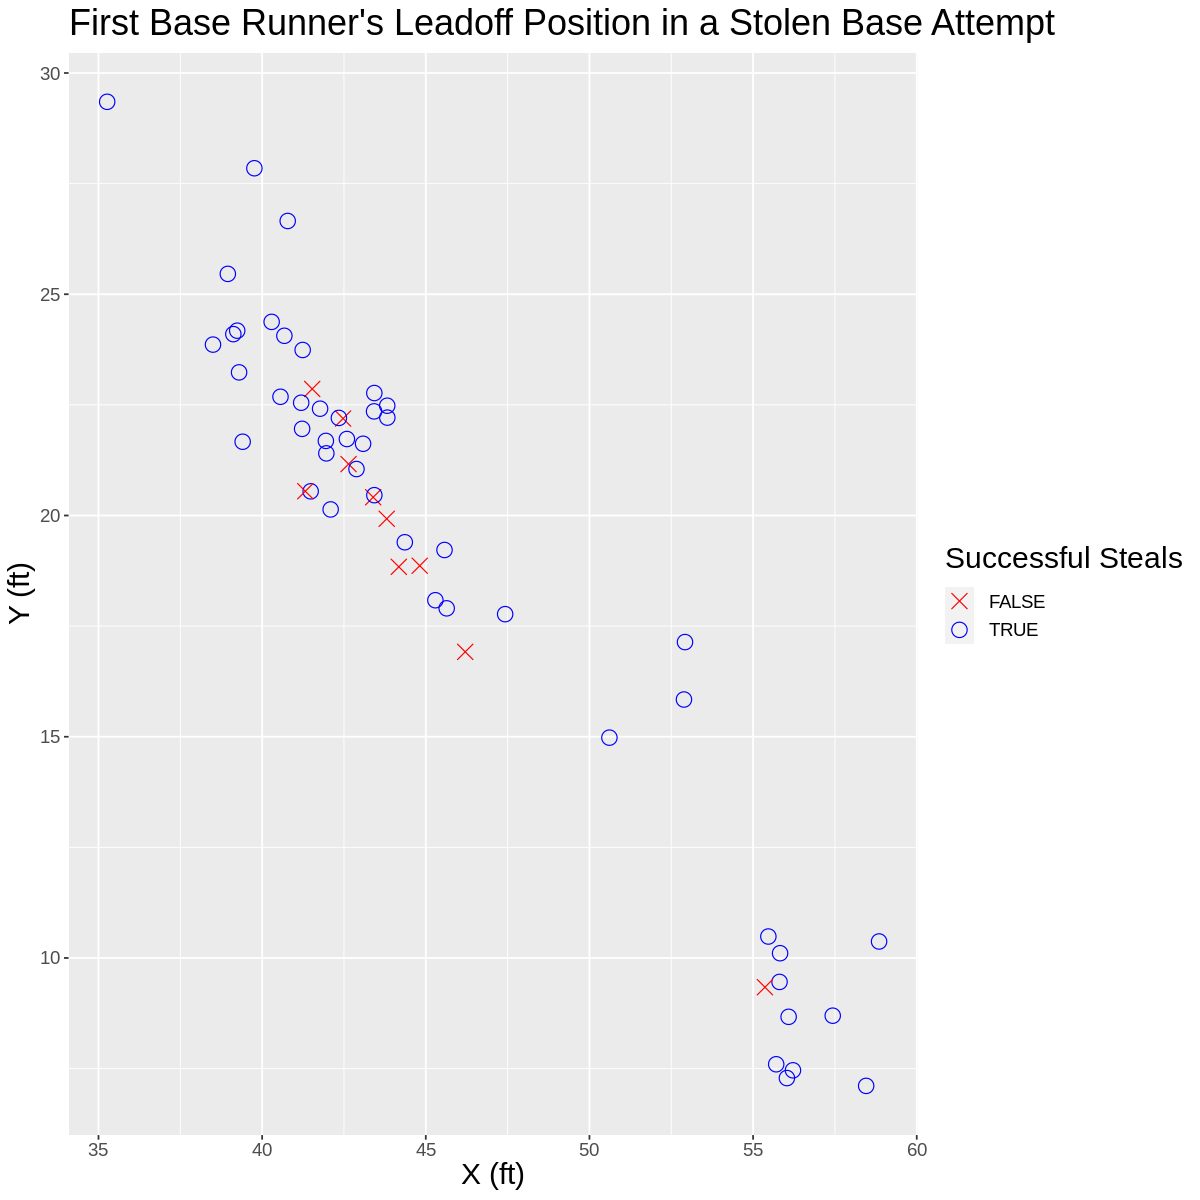

In [54]:
# make scatter plot
options(repr.plot.width = 10, repr.plot.height = 10) #size of graph

runner_xy_plot <- ggplot(normalize_df, aes(x = field_x, y = norm_y, shape = success, color = success)) +
  geom_point(size = 4) +
    #lims(x = c(0, 64), y = c(0, 64)) + #sets min and max x and y range
    scale_shape_manual(values = c(4, 1)) + # 1: Hollow Circle (FALSE), 4: Cross (TRUE)
      scale_color_manual(values = c("red", "blue")) +
        labs(
          title = "First Base Runner's Leadoff Position in a Stolen Base Attempt",
          x = "X (ft)",
          y = "Y (ft)",
          color = "Successful Steals",
          shape = "Successful Steals"
        ) +
        theme(
          text = element_text(size = 14),
          title = element_text(size = 18),
        )
print(runner_xy_plot)
#ggsave("test6.tiff", runner_xy_plot, width=12, height=10, units="in", dpi=300)